# Notebook Setup

**Import Required Modules**

In [1]:
import pandas as pd
import numpy as np
import shap 
from xgboost import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle 
import glob
from sklearn.metrics import r2_score
from xgboost import *

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


**Load the AR Climatology**

In [53]:
# Load the AR Climatology
ar_df = pd.read_csv('WestCoastAR-TCP_clustered.csv')
ar_df['month'] = pd.to_datetime(ar_df['datetime']).dt.month # At this point, this line is a meme & I love it

## Functions

**Makes lists of XGBmodel parameter files and retained feature pickles**

In [39]:
def grab_XGBfiles():


    Model_Param_List = glob.glob('*XGBmodel.txt')
    Model_Feature_List = glob.glob('*RetainedFeatures.pkl')

    return Model_Param_List, Model_Feature_List



**Modulates Testing-Training Splits among clustered XGB IVT models**

In [64]:
def clusterXGB_biasVariance(Model_Param_List,Model_Feature_List,ar_df):

    
    
    # Initiate the lists where we will store each cluster's bias-variance information
    cluster_labels = []  
    cluster_test_scores = []
    cluster_train_scores = []

    for i in range(len(Model_Param_List)):

        # Consider each AR cluster
        ar_df_cluster = ar_df.loc[ar_df['4_Clusters']==i]

        # Get each model's parameters and retained features
        params = Model_Param_List[i]
        with open(Model_Feature_List[i], 'rb') as f:
            features = pickle.load(f)
        

        # Initiate the XGB model using the parameter text file
        xgb_reg = XGBRegressor()
        xgb_reg.load_model(params)
        

        # Produce Target and Attributes from the DataFrame using the feature list from file
        y = ar_df_cluster['strength'] # hard coded
        x = ar_df_cluster[features] # dynamic

        # Begin the Bias-Variance Analysis by modulating the test-train split and running the model
        test_scores = [] # Initiate an empty list for the model's testing validation scores
        train_scores = [] # And the training validation scores

        # Modulate the test-train splits between 10-90%
        train_splits = np.arange(0.1,1,0.1)

        # Iterate through each partition
        for train_split in train_splits:

            # Split according to the partition value
            x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=train_split,random_state=42, shuffle=True)

            # Train the XGBoosted IVT regression tree
            xgb_reg.fit(x_train,y_train)

            # Make predictions of the target variable using
            y_pred_test = xgb_reg.predict(x_test)  # The testing dataset
            y_pred_train = xgb_reg.predict(x_train) # The training dataset

            # Evaluate the performance between testing & training via the coefficient of determination
            r2_train = r2_score(y_train,y_pred_train)
            r2_test = r2_score(y_test,y_pred_test)

            # Record the split's test-train validation
            train_scores.append(r2_train)
            test_scores.append(r2_test)

            

        # Append each clustered model's bias-variance information to the output lists
        cluster_test_scores.append(test_scores)
        cluster_train_scores.append(train_scores)

        cluster_labels.append(i) # Use labels to keep track of things

        
            


    return cluster_labels, cluster_test_scores, cluster_train_scores

**Makes a Bias-Variance Plot**

In [77]:
def bias_variance_plot(test_scores, train_scores, title):

    # Make the X-axis coordinates from the Training percentage splits
    splits = np.arange(0.1,1,0.1)

    # Plos the testing & training validation scores
    plt.plot(splits,test_scores,"-b",label='Testing')
    plt.plot(splits,train_scores,"-r",label='Training')

    # Make things look nice
    plt.legend(loc='best')
    plt.title(title)
    plt.xlabel('Training Split Percentage')
    plt.ylabel('Coefficient of Determination')

    plt.show()

    

**Makes Multiple Bias-Variance Plots**

In [79]:
def make_all_plots(cluster_test_scores,cluster_train_scores):


    for i in range(len(cluster_test_scores)):

        bias_variance_plot(cluster_test_scores[i], cluster_train_scores[i], 'Cluster {}'.format(i))



# Making the Bias-Variance Plots

## For the stratified XGBmodels

[12:30:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "num_leaves" } are not used.

[12:30:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "num_leaves" } are not used.

[12:30:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "num_leaves" } are not used.

[12:30:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "num_leaves" } are not used.

[12:30:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "num_leaves" } are not used.

[12:30:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "num_leaves" } are not used.

[12:30:07] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "num_leaves" } are not

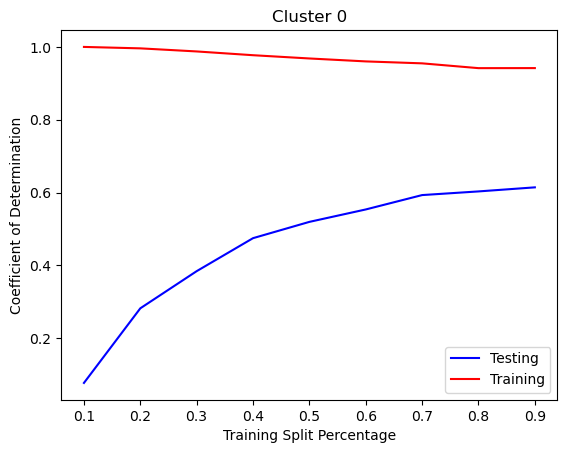

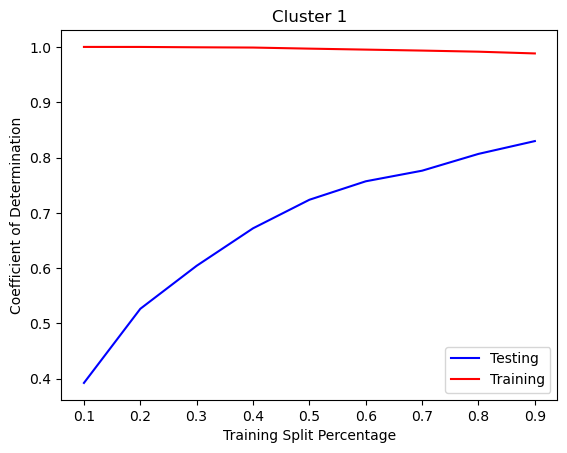

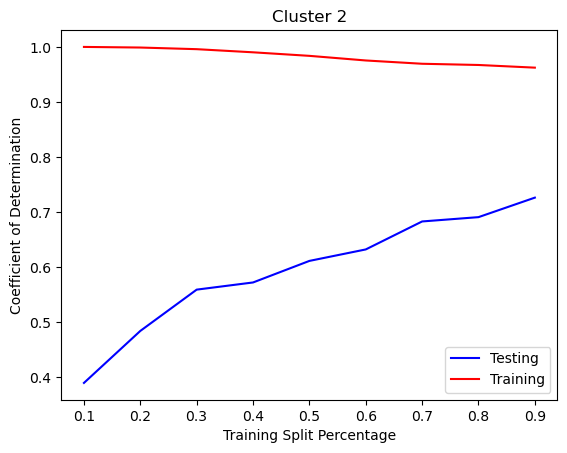

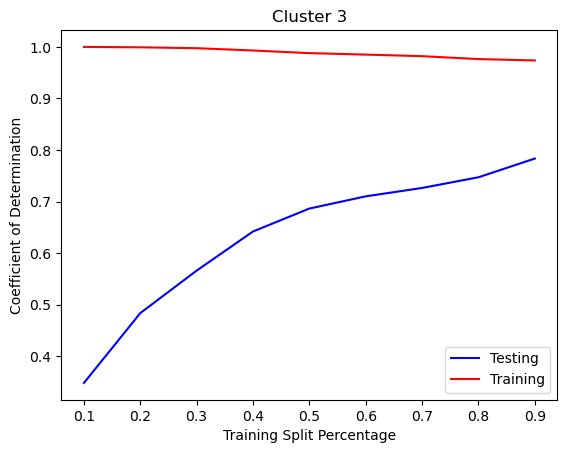

In [84]:
# Get the lists of filenames containing XGBmodel parameters and retained features
paramlist, featurelist = grab_XGBfiles()

# Build the XGB models for each cluster, modulate their test-training splits, and record their validation scores
cluster_labels, cluster_test_scores, cluster_train_scores = clusterXGB_biasVariance(paramlist,featurelist,ar_df)

# Bias-Variance plots for each cluster
make_all_plots(cluster_test_scores,cluster_train_scores)

## For the global XGBmodel

**XGBregressor setup**

In [97]:
# Predicting the strength of each AR
y = ar_df['strength']

# Using these attributes
x = ar_df[[ 'centroid_y', 'centroid_x', 'PMM', 'QBO', 'MEI', 'Curvature', 'Displacement', 'origin_lat',
       'Amplitude', 'pna_index_cdas', 'nao_index_cdas', 'month']] # Note that MJO Phase, origin_lon, and SSD_Theta (Axis Curvature) have been removed following the results of feature selection


# The optimal hyperparameters established during feature selection/hyperparameter optimization (Explicitly stated in another notebook; I should save the model params & features to file in the future...)
xgb_params =  {'n_estimators': 432, 
               'learning_rate': 0.387514395454483,
                 'num_leaves': 20 }

# Initiate the XGBoosted regression using the optimal hyperparameters 
xgb_reg = XGBRegressor(**xgb_params)

<bound method XGBModel.get_params of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.387514395454483,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=432, n_jobs=None, num_leaves=20,
             num_parallel_tree=None, predictor=None, ...)>

**Modulate the testing-training splits and record the model's validation score**

In [ ]:
# Same levels as for the stratified models
splits = np.arange(0.1,1,0.1)

# Make the output lists for validation scores
train_scores_g = []
test_scores_g = []

# Iterate through each split and record test-train validation
for split in splits:

    # Seperate into Test-Train splits
    x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=split,random_state=42, shuffle=True)

    # Fit the model
    xgb_reg.fit(x_train,y_train)

    # Make predictions of the target variable using
    y_pred_test = xgb_reg.predict(x_test)  # The testing dataset
    y_pred_train = xgb_reg.predict(x_train) # The training dataset

    # Evaluate the performance between testing & training via the coefficient of determination
    r2_train = r2_score(y_train,y_pred_train)
    r2_test = r2_score(y_test,y_pred_test)

    # Record the split's test-train validation
    train_scores_g.append(r2_train)
    test_scores_g.append(r2_test)

    

    

**Make a Bias-Variance Plot**

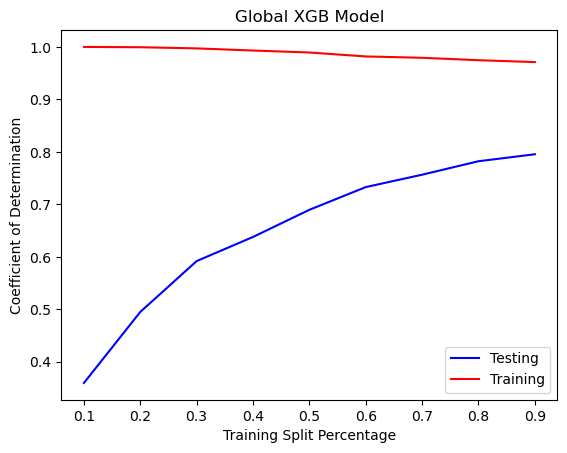

In [83]:
bias_variance_plot(test_scores_g, train_scores_g, "Global XGB Model")